Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Variational autoencoder network with MedNIST Dataset

This notebook illustrates the use of the variational autoencoder in MONAI for the purpose of image deblurring/denoising.

# Learning objectives
This will go through the steps of using MONAI's in-built VarAutoEncoder.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/varautoencoder_mednist.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 64.6 MB/s eta 0:00:00


## Setup imports

In [2]:
import time
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import VarAutoEncoder
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    ScaleIntensityD,
    EnsureTypeD,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.5.dev2509
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5f85a7bfd54b91be03213999a7c177bfe2d583b2
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp00aeg7i0


In [4]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Create small visualisation function
def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap="gray")
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 1. Get the data

This notebook can use the MedNIST or the MNIST datasets.
<br>
<br>
<br>
The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

In [6]:
def get_mednist_data(mednist_folder):
    resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
    md5 = "0bc7306e7427e00ad1c5526a6677552d"

    compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
    if not os.path.exists(mednist_folder):
        download_and_extract(resource, compressed_file, root_dir, md5)

In [7]:
def get_mnist_data(mnist_folder):
    if not os.path.exists(mnist_folder):
        os.makedirs(mnist_folder)
    if len(os.listdir(mnist_folder)) < 60000:
        mnist_fname = os.path.join(root_dir, "MNIST.gz")
        if not os.path.exists(mnist_fname):
            mnist_train_url = "http://yann.lecun.com/" + "exdb/mnist/train-images-idx3-ubyte.gz"
            urlretrieve(mnist_train_url, mnist_fname)
        f = gzip.open(mnist_fname, "r")
        f.read(16)  # Skip first 16 bytes
        image_size = 28
        num_images = 60000
        buf = f.read(image_size * image_size * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, image_size, image_size)

    for i in trange(data.shape[0]):
        im = np.squeeze(data[i])
        rescaled = (255.0 / im.max() * (im - im.min())).astype(np.uint8)
        pil_im = Image.fromarray(rescaled)
        pil_im.save(os.path.join(mnist_folder, f"mnist_{i}.png"))

MedNIST.tar.gz: 59.0MB [00:01, 59.9MB/s]                            

2025-03-07 18:56:15,028 - INFO - Downloaded: /tmp/tmp00aeg7i0/MedNIST.tar.gz


2025-03-07 18:56:15,215 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-03-07 18:56:15,221 - INFO - Writing into directory: /tmp/tmp00aeg7i0.


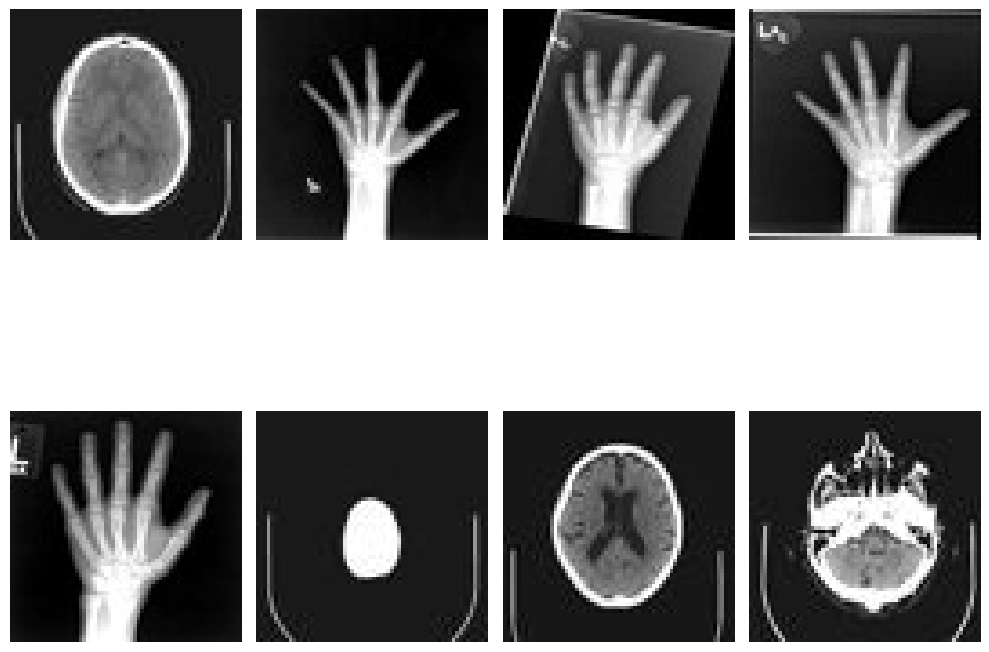

In [8]:
use_mnist = False
if use_mnist:
    im_dir = os.path.join(root_dir, "MNIST")
    get_mnist_data(im_dir)
else:
    data_dir = os.path.join(root_dir, "MedNIST")
    get_mednist_data(data_dir)
    # could be any combination of
    # ["AbdomenCT", "BreastMRI", "CXR", "ChestCT", "Hand", "HeadCT"]
    scan_types = ["Hand", "HeadCT"]
    all_filenames = []
    for scan_type in scan_types:
        im_dir = os.path.join(data_dir, scan_type)
        all_filenames += [os.path.join(im_dir, filename) for filename in os.listdir(im_dir)]
random.shuffle(all_filenames)

# Visualise a few of them
rand_images = np.random.choice(all_filenames, 8, replace=False)
plot_ims(rand_images, shape=(2, 4))

In [9]:
# Split into training and testing
test_frac = 0.2
num_ims = len(all_filenames)
num_test = int(num_ims * test_frac)
num_train = num_ims - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]
print(f"total number of images: {num_ims}")
print(f"number of images for training: {len(train_datadict)}")
print(f"number of images for testing: {len(test_datadict)}")

total number of images: 20000
number of images for training: 16000
number of images for testing: 4000


# 2. Create dataset and dataloader

Hold data and present batches during training.

In [10]:
batch_size = 128
num_workers = 10

transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        EnsureChannelFirstD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
    ]
)

train_ds = CacheDataset(train_datadict, transforms, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_ds = CacheDataset(test_datadict, transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Loading dataset: 100%|██████████| 16000/16000 [00:33<00:00, 475.61it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading dataset: 100%|██████████| 4000/4000 [00:08<00:00, 485.14it/s]


# 3. Train

For our loss we'll want to use a combination of a reconstruction loss (here, BCE) and KLD. By increasing the importance of the KLD loss with `beta`, we encourage the network to disentangle the latent generative factors.

In [11]:
BCELoss = torch.nn.BCELoss(reduction="sum")


def loss_function(recon_x, x, mu, log_var, beta):
    bce = BCELoss(recon_x, x)
    kld = -0.5 * beta * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kld


def train(in_shape, max_epochs, latent_size, learning_rate, beta):
    model = VarAutoEncoder(
        spatial_dims=2,
        in_shape=in_shape,
        out_channels=1,
        latent_size=latent_size,
        channels=(16, 32, 64),
        strides=(1, 2, 2),
    ).to(device)

    # Create optimiser
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    avg_train_losses = []
    test_losses = []

    t = trange(max_epochs, leave=True, desc="epoch 0, average train loss: ?, test loss: ?")
    for epoch in t:
        model.train()
        epoch_loss = 0
        for batch_data in train_loader:
            inputs = batch_data["im"].to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var, _ = model(inputs)
            loss = loss_function(recon_batch, inputs, mu, log_var, beta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_losses.append(epoch_loss / len(train_loader.dataset))

        # Test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data["im"].to(device)
                recon, mu, log_var, _ = model(inputs)
                # sum up batch loss
                test_loss += loss_function(recon, inputs, mu, log_var, beta).item()
        test_losses.append(test_loss / len(test_loader.dataset))

        t.set_description(  # noqa: B038
            f"epoch {epoch + 1}, average train loss: " f"{avg_train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}"
        )
    return model, avg_train_losses, test_losses

In [12]:
max_epochs = 50
learning_rate = 1e-4
beta = 100  # KL beta weighting. increase for disentangled VAE
latent_size = 2
# VAE constructor needs image shape
im_shape = transforms(train_datadict[0])["im"].shape
model, avg_train_losses, test_losses = train(im_shape, max_epochs, latent_size, learning_rate, beta)

epoch 50, average train loss: 1947.7738, test loss: 1949.7580: 100%|██████████| 50/50 [2:59:35<00:00, 215.52s/it]


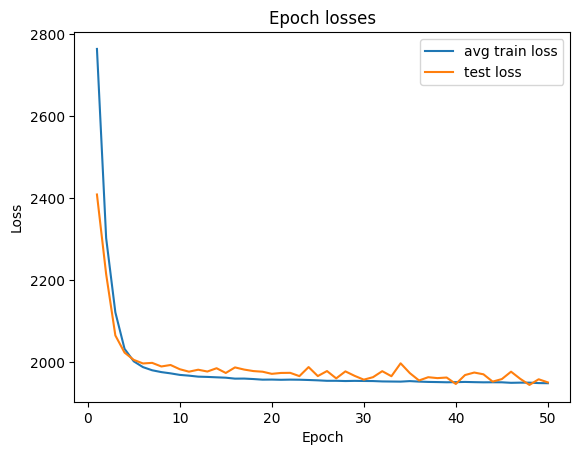

In [13]:
plt.figure()
plt.title("Epoch losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
for y, label in zip([avg_train_losses, test_losses], ["avg train loss", "test loss"]):
    x = list(range(1, len(y) + 1))
    (line,) = plt.plot(x, y)
    line.set_label(label)
plt.legend()

# Scatter plot distribution
Take each of the images in the training and test datasets and plot where they fit into the distribution (for latent size of 2 or 3).

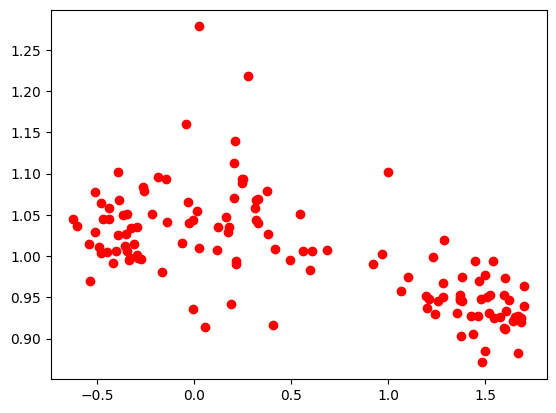

In [14]:
for j, loader in enumerate([train_loader, test_loader]):
    for i, batch_data in enumerate(loader):
        inputs = batch_data["im"].to(device)
        o = model.reparameterize(*model.encode_forward(inputs)).detach().cpu().numpy()
        if i + j == 0:
            latent_coords = o
        else:
            np.vstack((latent_coords, o))

if latent_size < 4:
    fig = plt.figure()
    if latent_size == 2:
        plt.scatter(latent_coords[:, 0], latent_coords[:, 1], c="r", marker="o")
    elif latent_size == 3:
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(latent_coords[:, 0], latent_coords[:, 1], latent_coords[:, 2], c="r", marker="o")
        ax.set_xlabel("dim 1")
        ax.set_ylabel("dim 2")
        ax.set_zlabel("dim 3")

# Visualise images produced by sampling the latent space
Visualising high dimensional data can always be tricky. If our latent size is 2, this is easy as we can vary `x` and `y` and see their effect on the generated image. For higher dimension data, one approach might be to vary two of the variables and fix the rest at 0, i.e., create a 2D slice through the N-dimensional data.

<Figure size 2000x1200 with 0 Axes>

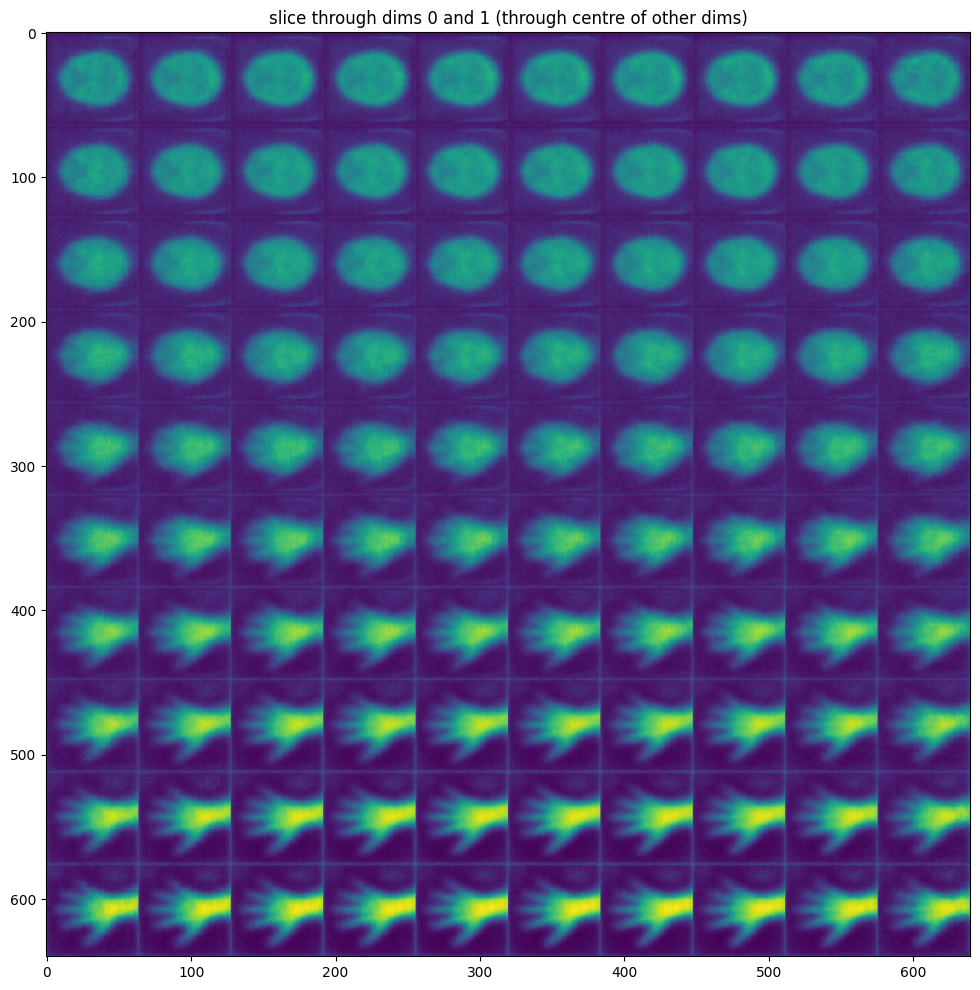

In [15]:
%matplotlib inline
num_ims = 10
pl.figure(figsize=(20, 12))
out = [[[] for _ in range(num_ims)] for _ in range(latent_size - 1)]
dist = torch.distributions.normal.Normal(torch.tensor(0.0), torch.tensor(1.0))
model.eval()
with torch.no_grad():
    for z in range(latent_size - 1):
        for z in range(latent_size - 1):
            for y, j in enumerate(torch.linspace(0.05, 0.95, num_ims)):
                for i in torch.linspace(0.05, 0.95, num_ims):
                    sample = torch.zeros(1, latent_size).to(device)
                    sample[0, z] = dist.icdf(j)
                    sample[0, z + 1] = dist.icdf(i)
                    o = model.decode_forward(sample)
                    o = o.detach().cpu().numpy().reshape(im_shape[1:])
                    out[z][y].append(o)

slices = np.block(out)

%matplotlib inline
pl.figure(figsize=(20, 12))
for i in range(slices.shape[0]):
    pl.imshow(slices[i])
    pl.title(f"slice through dims {i} and {i+1} (through centre of other dims)")
    if slices.shape[0] > 1:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.1)

#Exercise


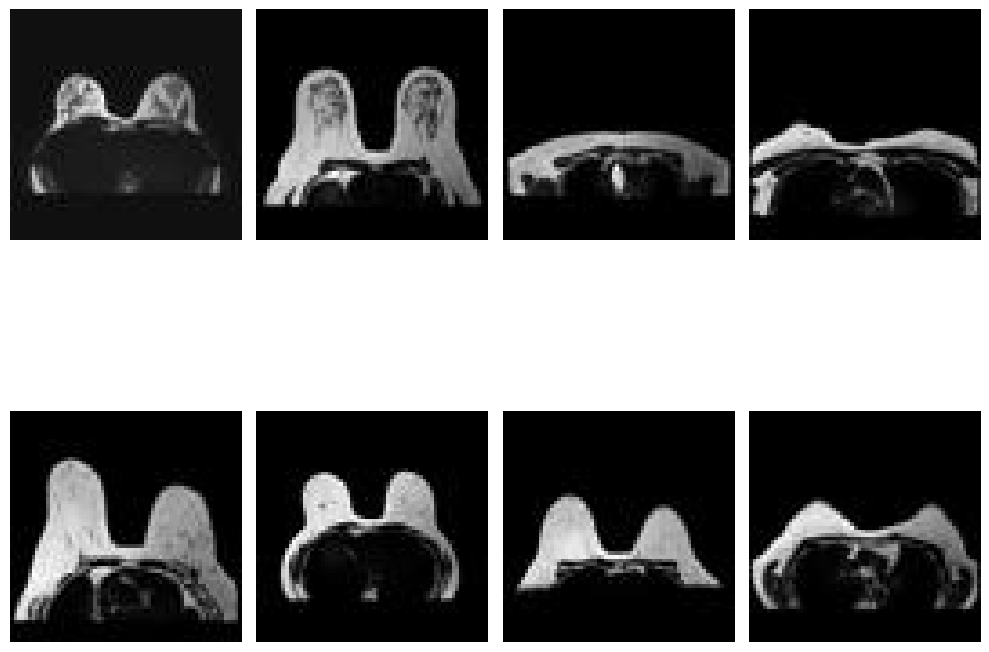

In [16]:
# Supongamos que 'data_dir' ya fue definido previamente, similar a tus otros datos
breast_dir = os.path.join(data_dir, "BreastMRI")
filenames_breast = [os.path.join(breast_dir, filename) for filename in os.listdir(breast_dir)]
random.shuffle(filenames_breast)

# Visualizar algunas imágenes de pechos
rand_images_breast = np.random.choice(filenames_breast, 8, replace=False)
plot_ims(rand_images_breast, shape=(2, 4))

In [1]:
# Espacio latente para manos y cabezas
latent_coords = None

for j, loader in enumerate([train_loader, test_loader]):
    for i, batch_data in enumerate(loader):
        inputs = batch_data["im"].to(device)
        # Supongo que 'model.encode_forward' y 'model.reparameterize' devuelven lo necesario
        o = model.reparameterize(*model.encode_forward(inputs)).detach().cpu().numpy()
        if latent_coords is None:
            latent_coords = o
        else:
            latent_coords = np.vstack((latent_coords, o))

# Espacio latente para pechos
breast_latent_coords = None

for i, batch_data in enumerate(breast_loader):
    inputs = batch_data["im"].to(device)
    o = model.reparameterize(*model.encode_forward(inputs)).detach().cpu().numpy()
    if breast_latent_coords is None:
        breast_latent_coords = o
    else:
        breast_latent_coords = np.vstack((breast_latent_coords, o))


NameError: name 'train_loader' is not defined

In [ ]:
if latent_size == 2:
    plt.figure(figsize=(8, 6))
    # Datos de entrenamiento (manos y cabezas) en rojo
    plt.scatter(latent_coords[:, 0], latent_coords[:, 1], c="r", marker="o", label="Manos y Cabezas")
    # Datos de pechos en azul
    plt.scatter(breast_latent_coords[:, 0], breast_latent_coords[:, 1], c="b", marker="^", label="Pechos (O.o.D)")
    plt.legend()
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title("Espacio Latente: Datos de entrenamiento vs Out-of-Distribution")
    plt.show()
elif latent_size == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(latent_coords[:, 0], latent_coords[:, 1], latent_coords[:, 2], c="r", marker="o", label="Manos y Cabezas")
    ax.scatter(breast_latent_coords[:, 0], breast_latent_coords[:, 1], breast_latent_coords[:, 2], c="b", marker="^", label="Pechos (O.o.D)")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.set_zlabel("Dim 3")
    ax.legend()
    plt.title("Espacio Latente: Datos de entrenamiento vs Out-of-Distribution")
    plt.show()


#Compute the reconstruction error of for some ood and training examples.

Explicación
Función de Error:
La función compute_reconstruction_error itera sobre los datos, pasa cada batch por el modelo y calcula el error MSE entre la salida reconstruida y la imagen original. Se suma el error de cada batch y se promedia dividiendo entre el número total de muestras.

Diferenciación entre Ejemplos de Entrenamiento y OOD:

Ejemplos de entrenamiento: Son aquellos con los que se entrenó el modelo (por ejemplo, imágenes de cerebro y manos).
Ejemplos OOD: Son los que el modelo no ha visto durante el entrenamiento (por ejemplo, imágenes de pechos).
Al comparar ambos valores, normalmente el error de reconstrucción en los ejemplos OOD será mayor, ya que el modelo no ha aprendido una representación adecuada para estos datos.

Este enfoque te permite cuantificar la capacidad del autoencoder para reconstruir los datos de entrada y detectar cuándo una imagen es "extraña" o fuera de la distribución esperada.

In [ ]:
import torch.nn.functional as F

def compute_reconstruction_error(model, data_loader, device):
    model.eval()  # Pone el modelo en modo evaluación
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            # Asumimos que las imágenes vienen en la clave "im"
            inputs = batch["im"].to(device)
            outputs = model(inputs)

            # Calculamos el error MSE de forma acumulada
            loss = F.mse_loss(outputs, inputs, reduction="sum")
            total_loss += loss.item()
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples  # error promedio por ejemplo
    return avg_loss

# Supongamos que 'model' ya está entrenado y 'device' definido (cpu o cuda)
train_reconstruction_error = compute_reconstruction_error(model, train_loader, device)
ood_reconstruction_error = compute_reconstruction_error(model, breast_loader, device)

print("Reconstruction Error (Training examples):", train_reconstruction_error)
print("Reconstruction Error (OOD examples):", ood_reconstruction_error)


#Perform an easy anomaly detection algorithm based on reconstruction error and/or latent space distribution to detect ood data.

In [ ]:
def get_latent_vectors(model, data_loader, device):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["im"].to(device)
            # Suponiendo que el método "encode" o alguna modificación del forward devuelve el vector latente.
            # Aquí se asume que tenemos una función `model.get_latent` que devuelve la representación latente.
            latent = model.get_latent(inputs)  # Necesitas implementarla o modificar el forward.
            latent_vectors.append(latent.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors

# Ejemplo: calcular centro y umbral basado en la distancia euclidiana
latent_train = get_latent_vectors(model, train_loader, device)
center = np.mean(latent_train, axis=0)
distances_train = np.linalg.norm(latent_train - center, axis=1)
latent_threshold = np.mean(distances_train) + 2 * np.std(distances_train)
print("Umbral en el espacio latente:", latent_threshold)


## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)